In [ ]:
import os
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

# -----------
from eval import eval
from utils import is_image_corrupt

In [151]:
# GPU setup configuration 
tf.keras.backend.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')

In [152]:
gpus

[]

In [153]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

strategy = tf.distribute.MirroredStrategy()
print(f"Number of GPUs: {strategy.num_replicas_in_sync}")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of GPUs: 1


In [131]:
# Constants from Environment Variables
IMAGE_SIZE = int(os.environ.get("IMAGE_SIZE", 224))
# Constants from Environment Variables for Image Limits
AD_IMAGE_LIMIT = 1800
NONAD_IMAGE_LIMIT = 1800
BATCH_SIZE = int(os.environ.get("BATCH_SIZE", 32))
EPOCHS = int(os.environ.get("EPOCHS", 10))
PATIENCE = int(os.environ.get("PATIENCE", 20))
DATASET_PATH = os.environ.get("DATASET_PATH", "/tf/dataset")
VERBOSE_LEVEL = int(os.environ.get("VERBOSE_LEVEL", 1))

config = {
    'IMAGE_SIZE': IMAGE_SIZE,
    'BATCH_SIZE': BATCH_SIZE,
    'EPOCHS': EPOCHS,
    'PATIENCE': PATIENCE,
    'DATASET_PATH': DATASET_PATH,
    'VERBOSE_LEVEL': VERBOSE_LEVEL,
    'AD_IMAGE_LIMIT': 1800,
    'NONAD_IMAGE_LIMIT': 1800
}

In [132]:
config

{'IMAGE_SIZE': 224,
 'BATCH_SIZE': 32,
 'EPOCHS': 10,
 'PATIENCE': 20,
 'DATASET_PATH': '/tf/dataset',
 'VERBOSE_LEVEL': 1,
 'AD_IMAGE_LIMIT': 1800,
 'NONAD_IMAGE_LIMIT': 1800}

In [133]:
with strategy.scope():
    base_model = ResNet50(weights='imagenet', include_top=False)
    for layer in base_model.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Function to load and preprocess a single image
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return tf.keras.applications.resnet50.preprocess_input(img)

# Custom generator
def custom_generator(file_paths, labels, batch_size, target_size):
    num_samples = len(file_paths)
    while True:  # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_paths = file_paths[offset:offset + batch_size]
            batch_labels = labels[offset:offset + batch_size]

            images = [preprocess_image(path, target_size) for path in batch_paths]
            images = np.vstack(images)
            
            yield images, np.array(batch_labels)

# Function to recursively collect all image file paths in a given directory
def collect_image_paths(root_dir, label, image_limit):
    file_paths = []
    labels = []
    corrupt_images_log = "corrupt_images.log"

    image_limit = None if image_limit == "all" else int(image_limit)
    image_count = 0

    print(f"Scanning in directory: {root_dir}")  # Debugging print
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if image_limit is not None and image_count >= image_limit:
                return file_paths, labels

            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(subdir, file)

                if is_image_corrupt(file_path):
                    with open(corrupt_images_log, "a") as log:
                        log.write(file_path + "\n")
                    continue

                file_paths.append(file_path)
                labels.append(label)
                image_count += 1

    if not file_paths:
        print("No images found. Check the directory path and file extensions.")  # Debugging print

    return file_paths, labels

In [134]:
# Collect image paths and labels
ad_paths, ad_labels = collect_image_paths(os.path.join(DATASET_PATH, 'ad'), 0, AD_IMAGE_LIMIT)
nonad_paths, nonad_labels = collect_image_paths(os.path.join(DATASET_PATH, 'nonAd'), 1, NONAD_IMAGE_LIMIT)

file_paths = ad_paths + nonad_paths
labels = ad_labels + nonad_labels

Scanning in directory: /tf/dataset/ad
Scanning in directory: /tf/dataset/nonAd


In [135]:
len(nonad_paths)

1800

In [136]:
import matplotlib.pyplot as plt
from PIL import Image

def display_images(image_paths, num_images=10, offset=0):
    """
    Displays a specific number of images from the provided list of image paths, starting from a given offset.

    :param image_paths: List of paths to the images.
    :param num_images: Number of images to display.
    :param offset: Starting index in image_paths from which to display images.
    """
    # Adjust the offset and num_images if they are out of bounds
    if offset < 0:
        print("Offset is negative. Starting from the beginning.")
        offset = 0

    if offset >= len(image_paths):
        print("Offset is beyond the list length. Showing the last images.")
        offset = max(0, len(image_paths) - num_images)

    end_index = min(offset + num_images, len(image_paths))
    
    plt.figure(figsize=(15, 10))  # Adjust the size as needed

    for i, path in enumerate(image_paths[offset:end_index], start=1):
        img = Image.open(path)
        plt.subplot((num_images + 4) // 5, 5, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image {offset + i}")

    plt.tight_layout()
    plt.show()

In [137]:
train_paths, val_paths, train_labels, val_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

train_generator = custom_generator(train_paths, train_labels, BATCH_SIZE, (IMAGE_SIZE, IMAGE_SIZE))
val_generator = custom_generator(val_paths, val_labels, BATCH_SIZE, (IMAGE_SIZE, IMAGE_SIZE))

train_steps = len(train_paths) // BATCH_SIZE
val_steps = len(val_paths) // BATCH_SIZE

In [138]:
len(train_paths)

2880

# Test the data we pass to the model to learn

In [139]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import matplotlib.image as img

def show_images_from_generator(generator, num_images=5):
    # Get a batch of images and labels from the generator
    batch_images, batch_labels = next(generator)

    # Display the images along with their labels
    for i in range(min(num_images, batch_images.shape[0])):
        image = batch_images[i]
        label = batch_labels[i]

        # Assuming the labels are in one-hot encoded format, find the index of the label
        label_index = np.argmax(label)

        # Display the image and label
        plt.imshow(image.astype('uint8'))  # Assuming images are in uint8 format
        plt.title(f"Label: {label_index}")
        plt.show()
    
def visualize_image_distribution(image_paths, labels, num_images=None):
    """Visualizes the distribution of image sizes."""
    # Calculate the maximum image size
    max_image_size = 0
    if num_images is not None:
        image_paths = image_paths[:num_images]
        labels = labels[:num_images]

    for image_path in image_paths:
        image = Image.open(image_path)
        image_size = image.size
        image_size_int = int(image_size[0])  # Convert the tuple to an integer
        max_image_size = max(max_image_size, image_size_int)

    # Set the upper limit of the image size axis slightly higher than the maximum image size found
    image_sizes = []
    for image_path in image_paths:
        image = Image.open(image_path)
        image_size = image.size
        image_size_int = int(image_size[0])
        image_sizes.append(image_size_int)

    plt.xlim(0, max_image_size * 1.1)

    # Visualize the distribution of image sizes
    plt.hist(image_sizes, bins=20)
    plt.xlabel('Image Size (pixels)')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Image Sizes (Subset of ' + str(num_images) + ')')
    plt.show()

def visualize_class_distribution(labels, num_classes=None):
    class_counts = Counter(labels)

    if num_classes is not None:
        class_counts = Counter(labels[:num_classes])

    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Class Label')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Class Labels')
    plt.show()

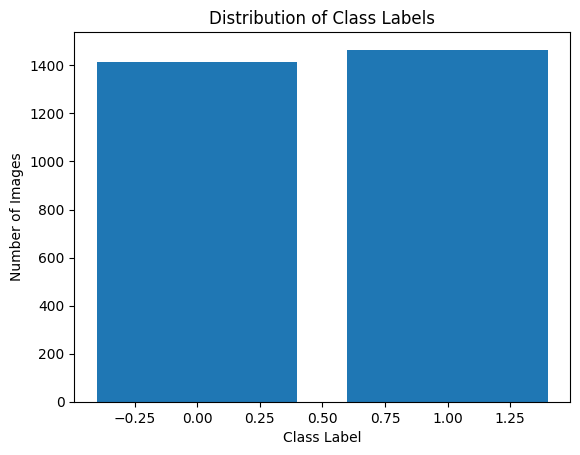

In [140]:
visualize_class_distribution(train_labels)

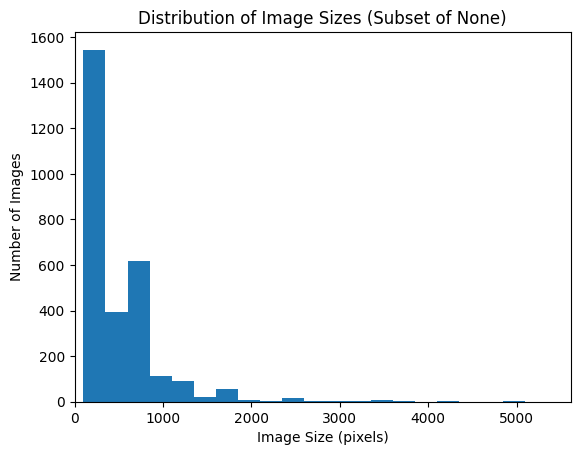

In [141]:
visualize_image_distribution(train_paths, train_labels)

In [142]:
show_images(train_paths, train_labels, 10, 2)

TypeError: show_images() takes from 1 to 2 positional arguments but 4 were given

In [ ]:
# CALLBACKS -----------------------------------
# Define a callback for dynamic checkpoint naming and specific folder
def get_checkpoint_callback(folder_name):
    checkpoint_dir = os.path.join("models", folder_name, "checkpoints")
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_callback = ModelCheckpoint(
        filepath=os.path.join(
            checkpoint_dir,
            "model_epoch_{epoch:04d}_loss_{loss:.4f}_acc_{accuracy:.4f}_val_loss_{val_loss:.4f}_val_acc_{val_accuracy:.4f}.h5",
        ),
        save_best_only=True,
        monitor="val_loss",  # Monitoring validation loss
        mode="min",
        save_weights_only=False,  # Save entire model
        verbose=VERBOSE_LEVEL,
    )
    return checkpoint_callback


# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",  # Metric to monitor (e.g., validation loss)
    patience=PATIENCE,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore the model weights from the epoch with the best value of the monitored metric
)

# Create a new directory for models
os.makedirs("models", exist_ok=True)

start_datetime = datetime.datetime.now()
current_model_folder_name = f'model_{start_datetime.strftime("%Y-%m-%d_%H-%M-%S")}'

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=f"models/{current_model_folder_name}/logs"
)

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_steps,
    verbose=VERBOSE_LEVEL,
    callbacks=[
        tensorboard_callback,
        get_checkpoint_callback(current_model_folder_name),
        early_stopping,
    ],
)

finish_datetime = datetime.datetime.now()

eval(model, val_generator, history, start_datetime, finish_datetime, config)

# Eval the model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image

In [ ]:
model = load_model("./models/model_2023-12-07_09-57-29/checkpoints/model_epoch_0006_loss_0.0000_acc_1.0000_val_loss_0.0005_val_acc_1.0000.h5")

In [ ]:
adImagePath = './test_images/ad.jpg'  # Path to the first unseen image
nonAdImagePath = './test_images/nonAd.jpg'  # Path to the first unseen image

# Read and resize the images
image_1 = Image.open(adImagePath).resize((224, 224))
image_1 = np.array(image_1)
image_2 = Image.open(nonAdImagePath).resize((224, 224))
image_2 = np.array(image_2)

# Preprocess the images to match the model's input format
images = np.array([image_1, image_2])
images = np.expand_dims(images, axis=3)  # Add the batch dimension


In [ ]:
predictions = model.predict(images)

# Get the class labels from the predictions
predicted_classes = np.argmax(predictions, axis=1)